# CAISO Day-Ahead Electricity Price Forecasting
##  Güneş Enerjisi + Yük Verileri


**Proje Amacı:** Geçmiş veriler VE dışsal değişkenlere (yük, yenilenebilir üretim) dayanarak ertesi günün 24 saatlik elektrik fiyatlarını tahmin etmek.


---

### 1. KÜTÜPHANELER

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("="*80)
print("CAISO ELECTRICITY PRICE FORECASTING - 6 MODEL COMPARISON")
print("="*80)

CAISO ELECTRICITY PRICE FORECASTING - 6 MODEL COMPARISON


### 2. VERİ YÜKLEME VE BİRLEŞTİRME

In [21]:
print("\nVeri yukleniyor...")

price_files = {
    2016: '../data/raw/2016 CAISO Day-Ahead Price.csv',
    2017: '../data/raw/2017 CAISO Day-Ahead Price.csv',
    2018: '../data/raw/2018 CAISO Day-Ahead Price.csv',
    2019: '../data/raw/2019 CAISO Day-Ahead Price.csv',
    2020: '../data/raw/2020 CAISO Day-Ahead Price.csv',
    2021: '../data/raw/2021 CAISO Day-Ahead Price.csv',
    2022: '../data/raw/2022 CAISO Day-Ahead Price.csv'
}

price_dfs = []
for year, filepath in price_files.items():
    try:
        df_temp = pd.read_csv(filepath)
        price_dfs.append(df_temp)
        print(f"Fiyat {year}: {len(df_temp)} satir")
    except Exception as e:
        print(f"Fiyat {year} yuklenemedi: {e}")

df_price = pd.concat(price_dfs, axis=0, ignore_index=True)
print(f"Toplam fiyat verisi: {len(df_price)} satir")

try:
    df_solar = pd.read_csv(
        '../data/raw/Net_generation_from_solar_for_California_(region)_hourly_-_UTC_time.csv',
        skiprows=5
    )
    print(f"Gunes enerjisi: {len(df_solar)} satir")
except Exception as e:
    print(f"Gunes enerjisi yuklenemedi: {e}")
    df_solar = None

try:
    df_load = pd.read_excel('../data/raw/CAISO Day-Ahead Load Data.xlsx')
    print(f"Yuk verisi: {len(df_load)} satir")
except Exception as e:
    print(f"Yuk verisi yuklenemedi: {e}")
    df_load = None


Veri yukleniyor...
Fiyat 2016: 35040 satir
Fiyat 2017: 34660 satir
Fiyat 2018: 34944 satir
Fiyat 2019: 35040 satir
Fiyat 2020: 35136 satir
Fiyat 2021: 34944 satir
Fiyat 2022: 16412 satir
Toplam fiyat verisi: 226176 satir
Gunes enerjisi: 34703 satir
Yuk verisi: 762929 satir


### 3. VERİ ÖN İŞLEME

In [22]:
print("\nVeri on isleme...")

df_price['DateTime'] = pd.to_datetime(df_price['Date'])
df_price = df_price.sort_values('DateTime').reset_index(drop=True)

df_sce = df_price[df_price['Zone'] == 'SCE'].copy()
df_sce = df_sce.drop('Zone', axis=1)
df_sce = df_sce.sort_values('DateTime').reset_index(drop=True)

df_sce = df_sce.drop_duplicates(subset='DateTime', keep='first')

df_sce = df_sce.set_index('DateTime')
full_range = pd.date_range(start=df_sce.index.min(), end=df_sce.index.max(), freq='H')
df_sce = df_sce.reindex(full_range)
df_sce['Price (cents/kWh)'] = df_sce['Price (cents/kWh)'].fillna(method='ffill')
df_sce = df_sce.reset_index().rename(columns={'index': 'DateTime'})

Q1 = df_sce['Price (cents/kWh)'].quantile(0.25)
Q3 = df_sce['Price (cents/kWh)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

df_sce.loc[df_sce['Price (cents/kWh)'] < lower_bound, 'Price (cents/kWh)'] = lower_bound
df_sce.loc[df_sce['Price (cents/kWh)'] > upper_bound, 'Price (cents/kWh)'] = upper_bound

print(f"SCE zone temizlendi: {len(df_sce)} satir")


Veri on isleme...
SCE zone temizlendi: 56712 satir


### 3. KESIFSEL VERI ANALIZI (EDA)


Kesifsel veri analizi yapiliyor...


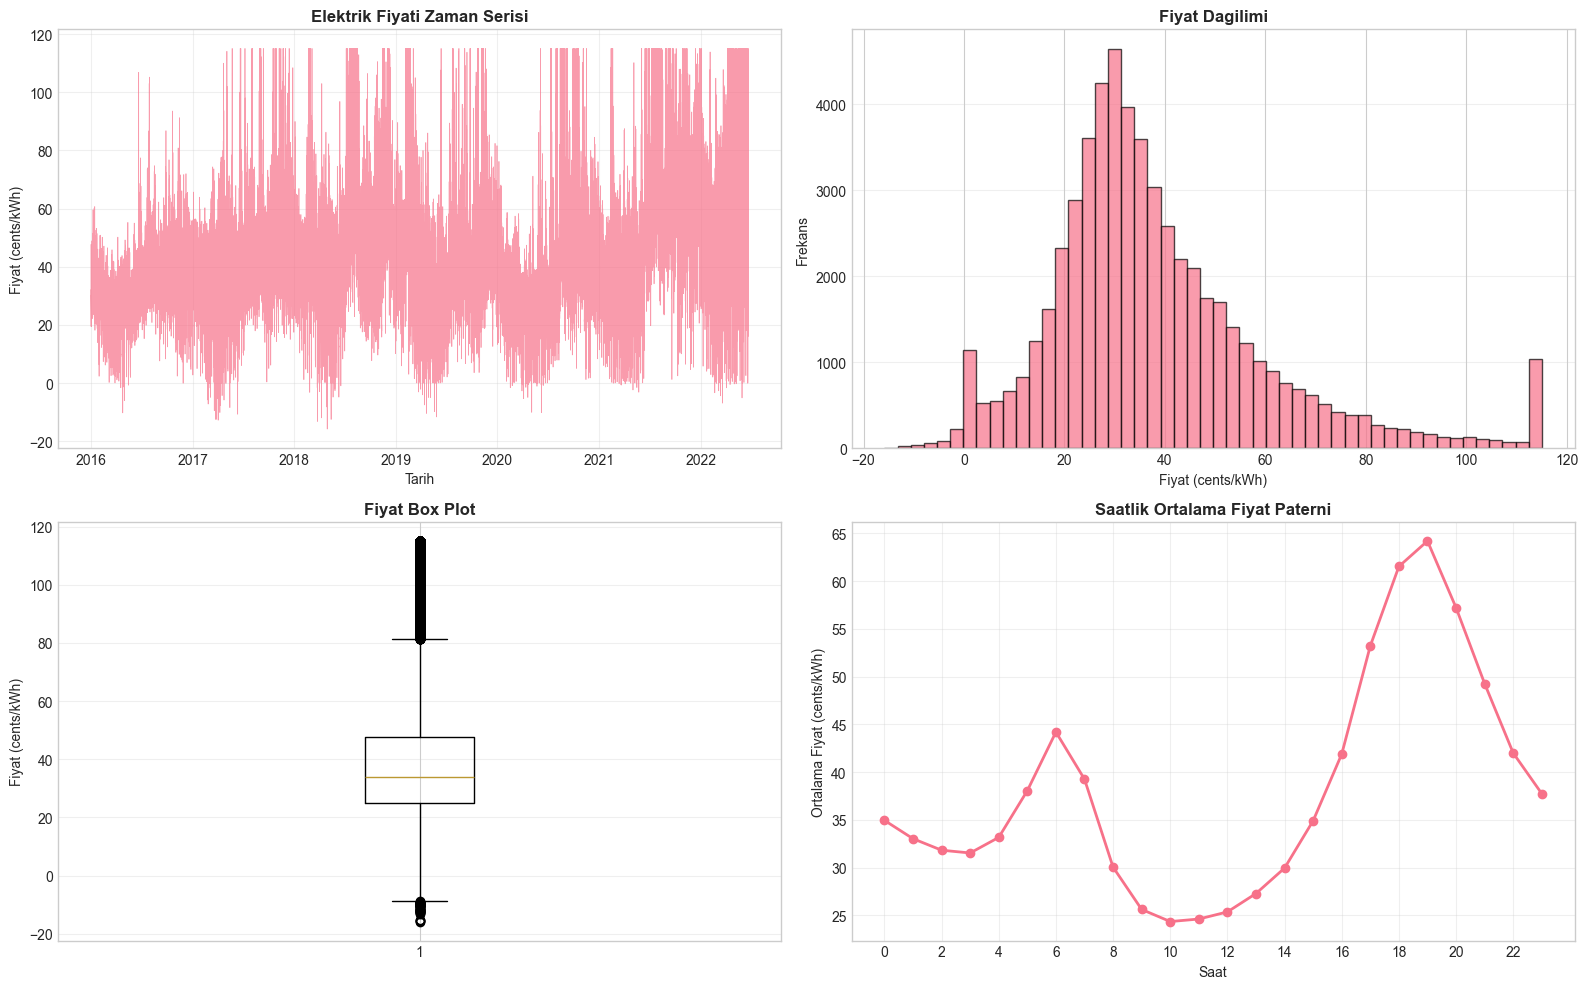

Temel EDA grafikleri kaydedildi

Fiyat Istatistikleri:
count    56712.000000
mean        38.134161
std         21.876695
min        -15.833060
25%         24.967495
50%         33.713130
75%         47.491287
max        115.062665
Name: Price (cents/kWh), dtype: float64


In [30]:
print("\nKesifsel veri analizi yapiliyor...")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Zaman serisi trendi
axes[0, 0].plot(df_sce['DateTime'], df_sce['Price (cents/kWh)'], linewidth=0.5, alpha=0.7)
axes[0, 0].set_title('Elektrik Fiyati Zaman Serisi', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Tarih')
axes[0, 0].set_ylabel('Fiyat (cents/kWh)')
axes[0, 0].grid(True, alpha=0.3)

# Histogram
axes[0, 1].hist(df_sce['Price (cents/kWh)'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Fiyat Dagilimi', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Fiyat (cents/kWh)')
axes[0, 1].set_ylabel('Frekans')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Box plot
axes[1, 0].boxplot(df_sce['Price (cents/kWh)'], vert=True)
axes[1, 0].set_title('Fiyat Box Plot', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Fiyat (cents/kWh)')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Saatlik ortalama pattern
hourly_avg = df_sce.groupby(df_sce['DateTime'].dt.hour)['Price (cents/kWh)'].mean()
axes[1, 1].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2)
axes[1, 1].set_title('Saatlik Ortalama Fiyat Paterni', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Saat')
axes[1, 1].set_ylabel('Ortalama Fiyat (cents/kWh)')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(range(0, 24, 2))

plt.tight_layout()
import os

output_dir = os.path.join('..', 'outputs')
os.makedirs(output_dir, exist_ok=True)
save_path = os.path.join(output_dir, 'eda_basic.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Temel EDA grafikleri kaydedildi")

# Istatistiksel ozetler
print("\nFiyat Istatistikleri:")
print(df_sce['Price (cents/kWh)'].describe())

### 3. ZAMAN SERISI ANALIZI


Zaman serisi analizi yapiliyor...

ADF Test:
  Test Istatistigi: -10.894936
  p-degeri: 0.000000
  Kritik Degerler: {'1%': np.float64(-3.430465434518198), '5%': np.float64(-2.8615910198183556), '10%': np.float64(-2.5667971561389433)}
  Sonuc: Seri DURAGAN

KPSS Test:
  Test Istatistigi: 1.447890
  p-degeri: 0.010000


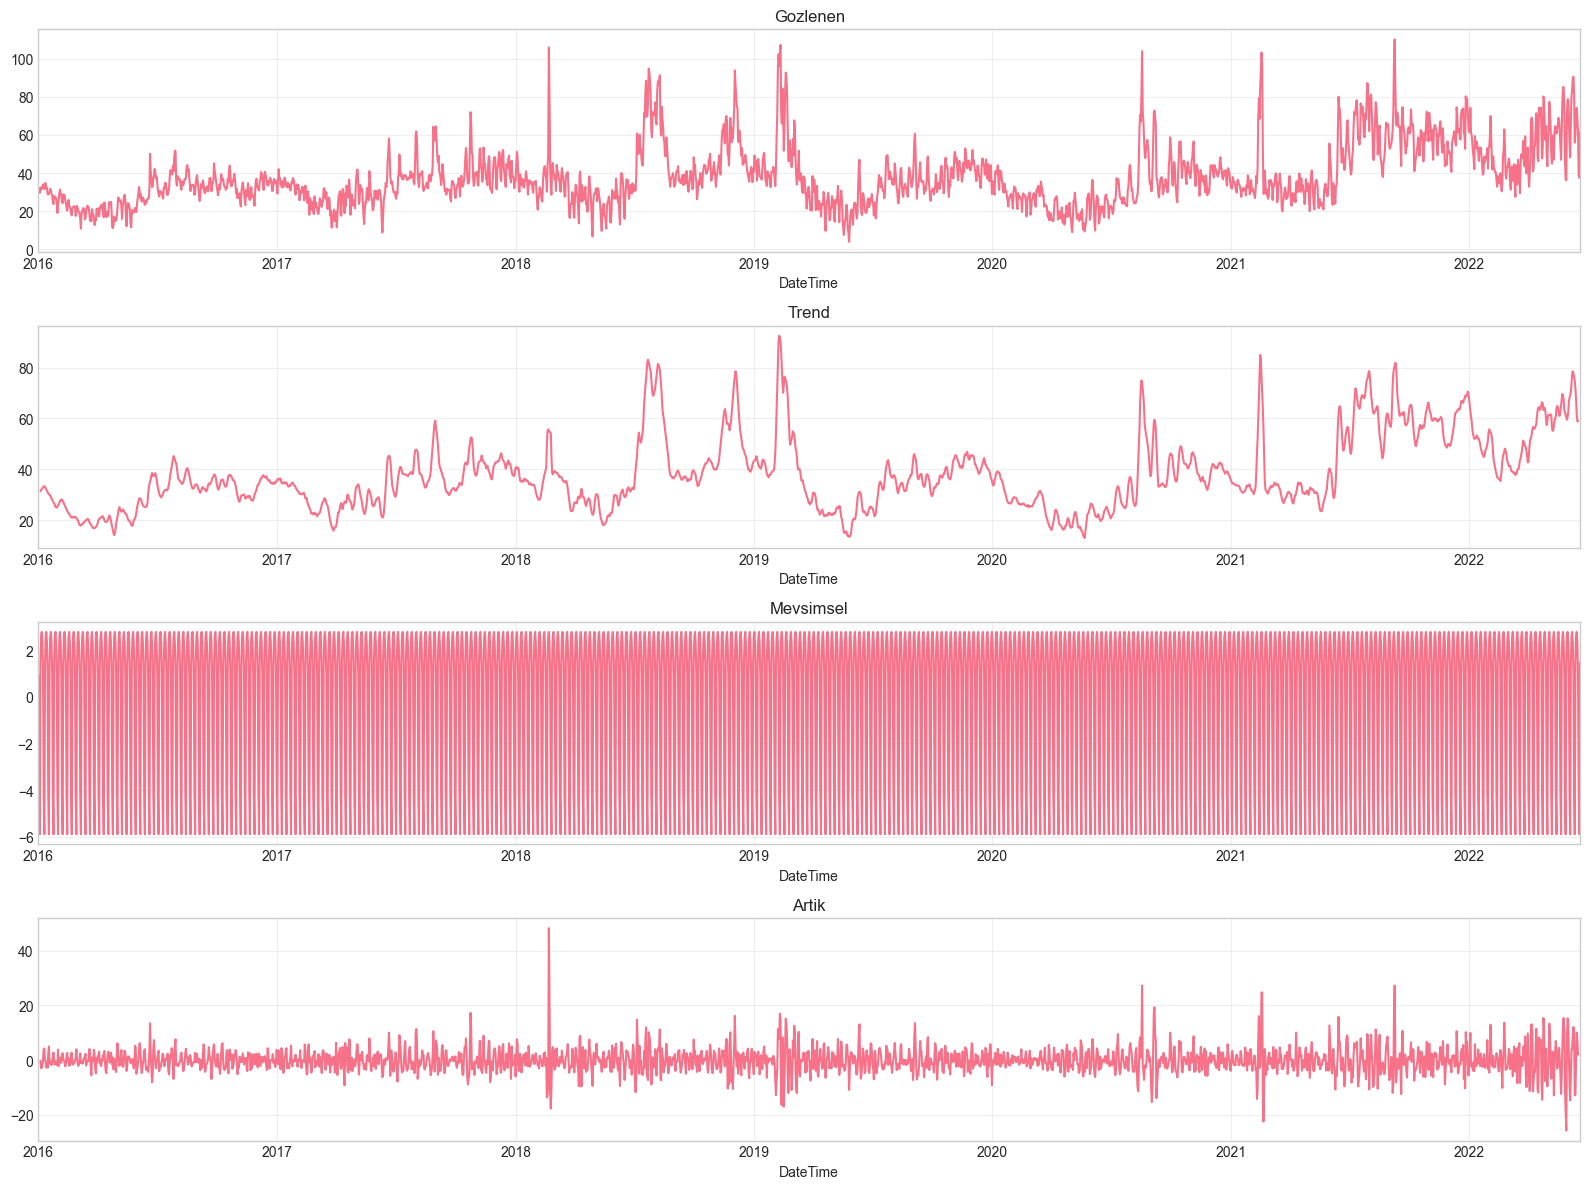

Decomposition grafigi kaydedildi


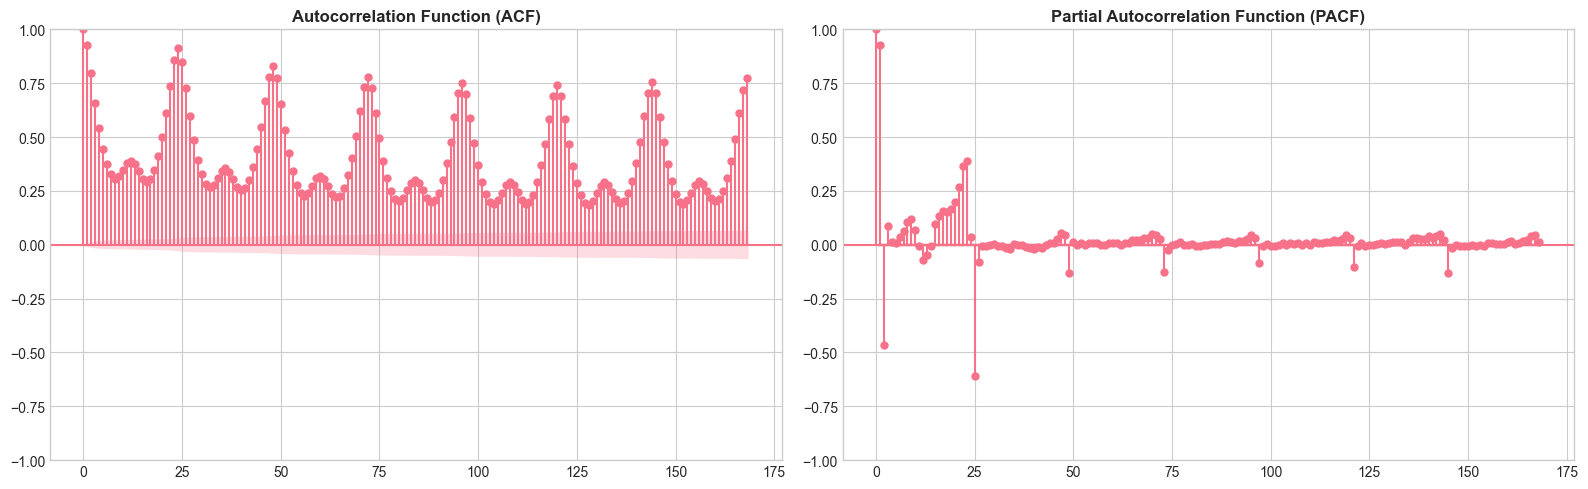

ACF/PACF grafikleri kaydedildi


In [31]:
print("\nZaman serisi analizi yapiliyor...")

import os
output_dir = os.path.join('..', 'outputs')
os.makedirs(output_dir, exist_ok=True)

# Duraganlik testleri
adf_result = adfuller(df_sce['Price (cents/kWh)'].dropna())
print(f"\nADF Test:")
print(f"  Test Istatistigi: {adf_result[0]:.6f}")
print(f"  p-degeri: {adf_result[1]:.6f}")
print(f"  Kritik Degerler: {adf_result[4]}")

if adf_result[1] < 0.05:
    print("  Sonuc: Seri DURAGAN")
else:
    print("  Sonuc: Seri DURAGAN DEGIL")

kpss_result = kpss(df_sce['Price (cents/kWh)'].dropna(), regression='ct')
print(f"\nKPSS Test:")
print(f"  Test Istatistigi: {kpss_result[0]:.6f}")
print(f"  p-degeri: {kpss_result[1]:.6f}")

# Decomposition
df_daily = df_sce.set_index('DateTime').resample('D')['Price (cents/kWh)'].mean()
decomposition = seasonal_decompose(df_daily, model='additive', period=7)

fig, axes = plt.subplots(4, 1, figsize=(16, 12))

decomposition.observed.plot(ax=axes[0], title='Gozlenen')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Mevsimsel')
decomposition.resid.plot(ax=axes[3], title='Artik')

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()


save_path_decomp = os.path.join(output_dir, 'decomposition.png')
plt.savefig(save_path_decomp, dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("Decomposition grafigi kaydedildi")

# ACF ve PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(df_sce['Price (cents/kWh)'].dropna(), lags=168, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=12, fontweight='bold')

plot_pacf(df_sce['Price (cents/kWh)'].dropna(), lags=168, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=12, fontweight='bold')

plt.tight_layout()

save_path_acf = os.path.join(output_dir, 'acf_pacf.png')
plt.savefig(save_path_acf, dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("ACF/PACF grafikleri kaydedildi")


### 4. DIŞSAL VERİLERİN ENTEGRASYONU


Dissal veriler entegre ediliyor...
Gunes enerjisi entegre edildi
Yuk verisi entegre edildi
Net yuk hesaplandi


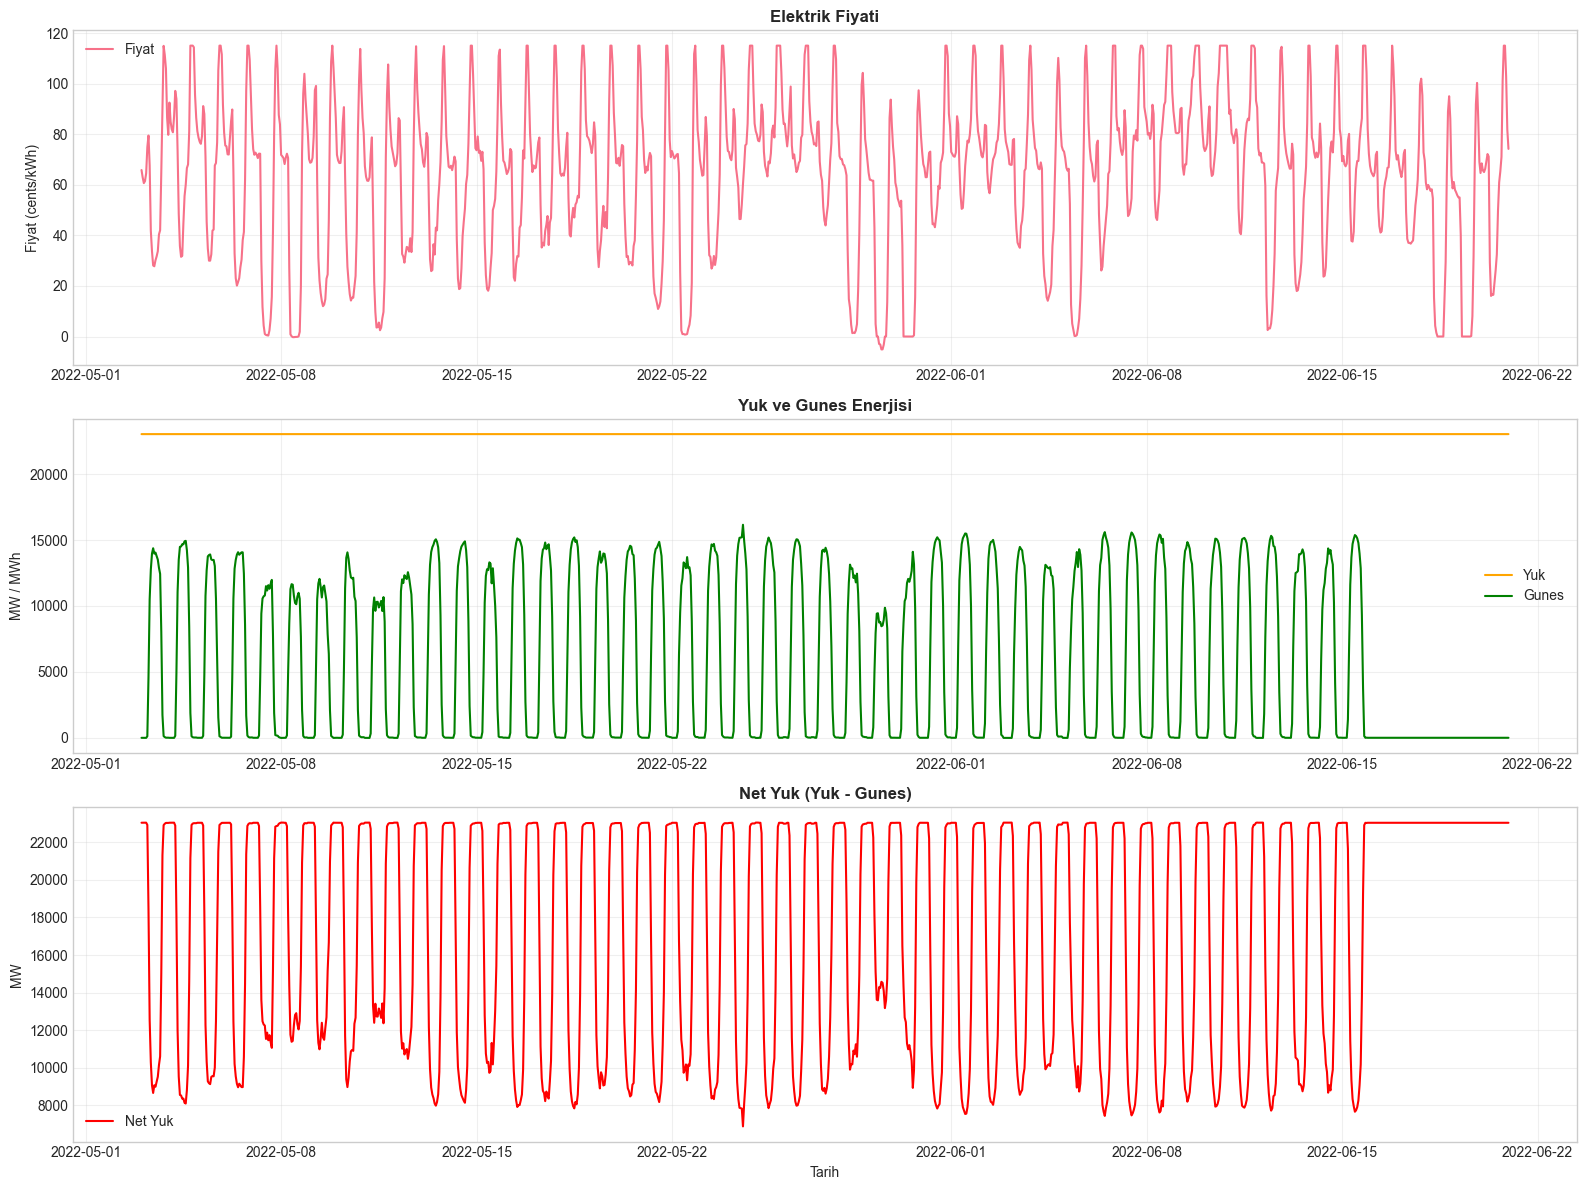

Dissal degisken grafikleri kaydedildi


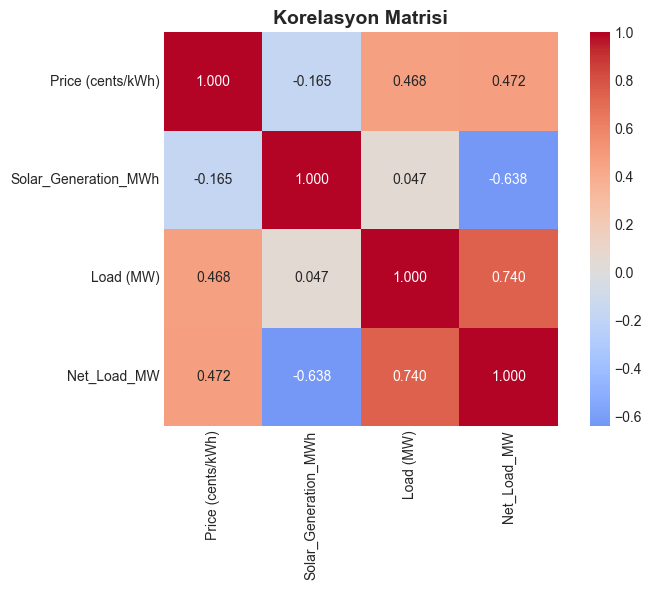

Korelasyon matrisi kaydedildi


In [32]:
print("\nDissal veriler entegre ediliyor...")

import os
output_dir = os.path.join('..', 'outputs')
os.makedirs(output_dir, exist_ok=True)

if df_solar is not None:
    try:
        df_solar.columns = ['DateTime_UTC', 'Solar_Generation_MWh']
        df_solar['DateTime_UTC'] = pd.to_datetime(df_solar['DateTime_UTC'], format='%m/%d/%Y %HH', errors='coerce')
        df_solar['DateTime'] = df_solar['DateTime_UTC'] - pd.Timedelta(hours=8)
        df_solar = df_solar[['DateTime', 'Solar_Generation_MWh']].dropna()
        df_solar = df_solar.groupby('DateTime')['Solar_Generation_MWh'].mean().reset_index()
        df_sce = df_sce.merge(df_solar, on='DateTime', how='left')
        df_sce['Solar_Generation_MWh'] = df_sce['Solar_Generation_MWh'].fillna(0)
        print("Gunes enerjisi entegre edildi")
    except Exception as e:
        print(f"Gunes enerjisi entegrasyonu basarisiz: {e}")
        df_sce['Solar_Generation_MWh'] = 0

if df_load is not None:
    try:
        df_load['DateTime'] = pd.to_datetime(df_load['Date'])
        if 'Zone' in df_load.columns:
            df_load_total = df_load[df_load['Zone'] == 'CA ISO'].copy()
        else:
            df_load_total = df_load.copy()
        df_load_total = df_load_total[['DateTime', 'Load (MW)']].dropna()
        df_load_total = df_load_total.groupby('DateTime')['Load (MW)'].mean().reset_index()
        df_sce = df_sce.merge(df_load_total, on='DateTime', how='left')
        df_sce['Load (MW)'] = df_sce['Load (MW)'].interpolate(method='linear')
        print("Yuk verisi entegre edildi")
    except Exception as e:
        print(f"Yuk verisi entegrasyonu basarisiz: {e}")
        df_sce['Load (MW)'] = 0

if 'Solar_Generation_MWh' in df_sce.columns and 'Load (MW)' in df_sce.columns:
    df_sce['Net_Load_MW'] = df_sce['Load (MW)'] - df_sce['Solar_Generation_MWh']
    print("Net yuk hesaplandi")

if 'Solar_Generation_MWh' in df_sce.columns and 'Load (MW)' in df_sce.columns:
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    
    sample_data = df_sce.iloc[-168*7:]
    
    axes[0].plot(sample_data['DateTime'], sample_data['Price (cents/kWh)'], label='Fiyat')
    axes[0].set_title('Elektrik Fiyati', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Fiyat (cents/kWh)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(sample_data['DateTime'], sample_data['Load (MW)'], label='Yuk', color='orange')
    axes[1].plot(sample_data['DateTime'], sample_data['Solar_Generation_MWh'], label='Gunes', color='green')
    axes[1].set_title('Yuk ve Gunes Enerjisi', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('MW / MWh')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    axes[2].plot(sample_data['DateTime'], sample_data['Net_Load_MW'], label='Net Yuk', color='red')
    axes[2].set_title('Net Yuk (Yuk - Gunes)', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('MW')
    axes[2].set_xlabel('Tarih')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()

    save_path_ext = os.path.join(output_dir, 'external_variables.png')
    plt.savefig(save_path_ext, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print("Dissal degisken grafikleri kaydedildi")
    
    corr_cols = ['Price (cents/kWh)', 'Solar_Generation_MWh', 'Load (MW)', 'Net_Load_MW']
    corr_matrix = df_sce[corr_cols].corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, square=True)
    plt.title('Korelasyon Matrisi', fontsize=14, fontweight='bold')
    plt.tight_layout()

    save_path_corr = os.path.join(output_dir, 'correlation_matrix.png')
    plt.savefig(save_path_corr, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print("Korelasyon matrisi kaydedildi")


### 6. ÖZELLİK MÜHENDİSLİĞİ 

In [38]:
print("\nOzellik muhendisligi...")

def create_time_features(df):
    df = df.copy()
    df['hour'] = df['DateTime'].dt.hour
    df['day'] = df['DateTime'].dt.day
    df['month'] = df['DateTime'].dt.month
    df['year'] = df['DateTime'].dt.year
    df['dayofweek'] = df['DateTime'].dt.dayofweek
    df['quarter'] = df['DateTime'].dt.quarter
    df['dayofyear'] = df['DateTime'].dt.dayofyear
    df['weekofyear'] = df['DateTime'].dt.isocalendar().week.astype(int)
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['is_month_start'] = df['DateTime'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['DateTime'].dt.is_month_end.astype(int)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    df['season'] = df['month'].apply(lambda x: 
        1 if x in [12, 1, 2] else 2 if x in [3, 4, 5] else 3 if x in [6, 7, 8] else 4)
    df['is_peak_hour'] = df['hour'].apply(lambda x: 1 if 17 <= x <= 21 else 0)
    df['is_night'] = df['hour'].apply(lambda x: 1 if x < 6 or x >= 22 else 0)
    df['is_morning'] = df['hour'].apply(lambda x: 1 if 6 <= x < 12 else 0)
    df['is_afternoon'] = df['hour'].apply(lambda x: 1 if 12 <= x < 17 else 0)
    df['is_evening'] = df['hour'].apply(lambda x: 1 if 17 <= x < 22 else 0)
    return df

def create_lag_features(df, target_col='Price (cents/kWh)', lags=[1, 2, 3, 24, 48, 168]):
    df = df.copy()
    for lag in lags:
        df[f'price_lag_{lag}'] = df[target_col].shift(lag)
    windows = [3, 6, 12, 24, 48, 168]
    for window in windows:
        df[f'price_rolling_mean_{window}'] = df[target_col].shift(1).rolling(window=window).mean()
        df[f'price_rolling_std_{window}'] = df[target_col].shift(1).rolling(window=window).std()
        df[f'price_rolling_min_{window}'] = df[target_col].shift(1).rolling(window=window).min()
        df[f'price_rolling_max_{window}'] = df[target_col].shift(1).rolling(window=window).max()
    df['price_ema_24'] = df[target_col].shift(1).ewm(span=24, adjust=False).mean()
    df['price_ema_168'] = df[target_col].shift(1).ewm(span=168, adjust=False).mean()
    df['price_change_1h'] = df[target_col].diff(1)
    df['price_change_24h'] = df[target_col].diff(24)
    df['price_change_pct_1h'] = df[target_col].pct_change(1)
    df['price_change_pct_24h'] = df[target_col].pct_change(24)
    return df

def create_external_features(df):
    df = df.copy()
    if 'Solar_Generation_MWh' in df.columns:
        for lag in [1, 24, 168]:
            df[f'solar_lag_{lag}'] = df['Solar_Generation_MWh'].shift(lag)
        for window in [24, 168]:
            df[f'solar_rolling_mean_{window}'] = df['Solar_Generation_MWh'].shift(1).rolling(window=window).mean()
            df[f'solar_rolling_max_{window}'] = df['Solar_Generation_MWh'].shift(1).rolling(window=window).max()
        df['solar_penetration'] = df['Solar_Generation_MWh'] / (df['Solar_Generation_MWh'].mean() + 1)
    if 'Load (MW)' in df.columns:
        for lag in [1, 24, 168]:
            df[f'load_lag_{lag}'] = df['Load (MW)'].shift(lag)
        for window in [24, 168]:
            df[f'load_rolling_mean_{window}'] = df['Load (MW)'].shift(1).rolling(window=window).mean()
            df[f'load_rolling_std_{window}'] = df['Load (MW)'].shift(1).rolling(window=window).std()
        df['load_change_24h'] = df['Load (MW)'].diff(24)
        df['load_change_pct_24h'] = df['Load (MW)'].pct_change(24)
    if 'Net_Load_MW' in df.columns:
        for lag in [1, 24, 168]:
            df[f'netload_lag_{lag}'] = df['Net_Load_MW'].shift(lag)
        for window in [24, 168]:
            df[f'netload_rolling_mean_{window}'] = df['Net_Load_MW'].shift(1).rolling(window=window).mean()
            df[f'netload_rolling_std_{window}'] = df['Net_Load_MW'].shift(1).rolling(window=window).std()
    if 'Solar_Generation_MWh' in df.columns and 'Load (MW)' in df.columns:
        df['solar_load_ratio'] = df['Solar_Generation_MWh'] / (df['Load (MW)'] + 1)
    return df

df_features = create_time_features(df_sce)
df_features = create_lag_features(df_features)
df_features = create_external_features(df_features)

initial_size = len(df_features)
df_features = df_features.dropna()

print(f"Ozellik sayisi: {len(df_features.columns)}")
print(f"Veri boyutu: {initial_size} -> {len(df_features)} satir")
df_features.head()



Ozellik muhendisligi...
Ozellik sayisi: 90
Veri boyutu: 56712 -> 56330 satir


,DateTime,Date,Price (cents/kWh),Solar_Generation_MWh,Load (MW),Net_Load_MW,hour,day,month,year,...,load_change_24h,load_change_pct_24h,netload_lag_1,netload_lag_24,netload_lag_168,netload_rolling_mean_24,netload_rolling_std_24,netload_rolling_mean_168,netload_rolling_std_168,solar_load_ratio
168,2016-01-08 00:00:00,1/8/16 0:00,25.81106,0.0,22572.0,22572.0,0,8,1,2016,...,461.0,0.020849,23934.0,22111.0,23419.0,25623.083333,2783.101428,24618.693452,2921.321966,0.0
169,2016-01-08 01:00:00,1/8/16 1:00,25.17743,0.0,21722.0,21722.0,1,8,1,2016,...,288.0,0.013437,22572.0,21434.0,22654.0,25642.291667,2759.296988,24613.651786,2924.134344,0.0
170,2016-01-08 02:00:00,1/8/16 2:00,24.46926,0.0,21208.0,21208.0,2,8,1,2016,...,233.0,0.011108,21722.0,20975.0,22039.0,25654.291667,2740.763690,24608.104167,2928.754862,0.0
171,2016-01-08 03:00:00,1/8/16 3:00,24.86369,0.0,21210.0,21210.0,3,8,1,2016,...,405.0,0.019466,21208.0,20805.0,21705.0,25664.000000,2723.828396,24603.157738,2933.817223,0.0
172,2016-01-08 04:00:00,1/8/16 4:00,25.56961,0.0,21756.0,21756.0,4,8,1,2016,...,440.0,0.020642,21210.0,21316.0,21707.0,25680.875000,2693.502219,24600.211310,2936.992114,0.0


### 7. VERI HAZIRLIGI

In [34]:
print("\nVeri hazirlanıyor...")

target = 'Price (cents/kWh)'
exclude_cols = ['DateTime', target, 'Date']
feature_cols = [col for col in df_features.columns if col not in exclude_cols]

df_features = df_features.replace([np.inf, -np.inf], np.nan)
df_features = df_features.fillna(method='ffill').fillna(method='bfill').fillna(0)

train_size = int(len(df_features) * 0.8)
val_size = int(len(df_features) * 0.10)

train_data = df_features.iloc[:train_size]
val_data = df_features.iloc[train_size:train_size+val_size]
test_data = df_features.iloc[train_size+val_size:]

print(f"Train: {len(train_data)} ({len(train_data)/len(df_features)*100:.1f}%)")
print(f"Val: {len(val_data)} ({len(val_data)/len(df_features)*100:.1f}%)")
print(f"Test: {len(test_data)} ({len(test_data)/len(df_features)*100:.1f}%)")

X_train = train_data[feature_cols]
y_train = train_data[target]
X_val = val_data[feature_cols]
y_val = val_data[target]
X_test = test_data[feature_cols]
y_test = test_data[target]

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()




Veri hazirlanıyor...
Train: 45064 (80.0%)
Val: 5633 (10.0%)
Test: 5633 (10.0%)


### 8 METRIK FONKSIYONLARI

In [39]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    wmape = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'WMAPE': wmape, 'R2': r2}

def print_metrics(metrics, model_name=''):
    print(f"\n{'='*60}")
    print(f"{model_name}")
    print(f"{'='*60}")
    print(f"MAE: {metrics['MAE']:.4f} cents/kWh")
    print(f"RMSE: {metrics['RMSE']:.4f} cents/kWh")
    print(f"MAPE: {metrics['MAPE']:.4f}%")
    print(f"WMAPE: {metrics['WMAPE']:.4f}%")
    print(f"R2: {metrics['R2']:.4f}")
    print(f"{'='*60}")


### 8 Modeller

MODEL 1: SARIMAX

In [43]:
print("\n[1/6] SARIMAX modeli egitiliyor...")

try:
    train_ts = train_data.set_index('DateTime')[target]
    
    sarimax_model = SARIMAX(
        train_ts,
        order=(1, 0, 0),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    sarimax_fit = sarimax_model.fit(disp=False, maxiter=50)
    
    y_train_pred_sarimax = sarimax_fit.fittedvalues
    y_val_pred_sarimax = sarimax_fit.forecast(steps=len(val_data))
    y_test_pred_sarimax = sarimax_fit.forecast(steps=len(val_data) + len(test_data))[-len(test_data):]
    
    train_metrics_sarimax = calculate_metrics(
        y_train.values[-len(y_train_pred_sarimax):], 
        y_train_pred_sarimax.values
    )
    val_metrics_sarimax = calculate_metrics(y_val.values, y_val_pred_sarimax.values)
    test_metrics_sarimax = calculate_metrics(y_test.values, y_test_pred_sarimax.values)
    
    print_metrics(train_metrics_sarimax, 'SARIMAX - Train')
    print_metrics(val_metrics_sarimax, 'SARIMAX - Validation')
    print_metrics(test_metrics_sarimax, 'SARIMAX - Test')
    
    sarimax_trained = True
    
except Exception as e:
    print(f"SARIMAX atlanıyor (zaman serisi modeli external features ile uyumlu degil): {e}")
    test_metrics_sarimax = {'MAE': 0, 'RMSE': 0, 'MAPE': 0, 'WMAPE': 0, 'R2': 0}
    val_metrics_sarimax = {'MAE': 0, 'RMSE': 0, 'MAPE': 0, 'WMAPE': 0, 'R2': 0}
    train_metrics_sarimax = {'MAE': 0, 'RMSE': 0, 'MAPE': 0, 'WMAPE': 0, 'R2': 0}
    sarimax_trained = False


[1/6] SARIMAX modeli egitiliyor...

SARIMAX - Train
MAE: 5.0816 cents/kWh
RMSE: 7.8711 cents/kWh
MAPE: inf%
WMAPE: 14.6046%
R2: 0.8364

SARIMAX - Validation
MAE: 48.4090 cents/kWh
RMSE: 54.4718 cents/kWh
MAPE: 100.1761%
WMAPE: 99.9235%
R2: -3.7574

SARIMAX - Test
MAE: 55.4871 cents/kWh
RMSE: 61.0704 cents/kWh
MAPE: inf%
WMAPE: 100.0000%
R2: -4.6980


MODEL 2: XGBOOST

In [51]:
print("\n[2/6] XGBoost modeli egitiliyor...")

xgb_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 1000,
    'max_depth': 8,
    'learning_rate': 0.03,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'colsample_bylevel': 0.8,
    'min_child_weight': 5,
    'gamma': 0.2,
    'reg_alpha': 0.5,
    'early_stopping_rounds': 100,
    'reg_lambda': 2.0,
    'random_state': 42,
    'n_jobs': -1
}

xgb_model = xgb.XGBRegressor(**xgb_params)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

y_train_pred_xgb = xgb_model.predict(X_train)
y_val_pred_xgb = xgb_model.predict(X_val)
y_test_pred_xgb = xgb_model.predict(X_test)

train_metrics_xgb = calculate_metrics(y_train, y_train_pred_xgb)
val_metrics_xgb = calculate_metrics(y_val, y_val_pred_xgb)
test_metrics_xgb = calculate_metrics(y_test, y_test_pred_xgb)

print_metrics(train_metrics_xgb, 'XGBoost - Train')
print_metrics(val_metrics_xgb, 'XGBoost - Validation')
print_metrics(test_metrics_xgb, 'XGBoost - Test')


[2/6] XGBoost modeli egitiliyor...

XGBoost - Train
MAE: 0.1270 cents/kWh
RMSE: 0.1727 cents/kWh
MAPE: inf%
WMAPE: 0.3649%
R2: 0.9999

XGBoost - Validation
MAE: 0.3840 cents/kWh
RMSE: 0.7365 cents/kWh
MAPE: 3.3376%
WMAPE: 0.7927%
R2: 0.9991

XGBoost - Test
MAE: 0.7033 cents/kWh
RMSE: 1.4524 cents/kWh
MAPE: inf%
WMAPE: 1.2676%
R2: 0.9968


MODEL 3: LSTM

In [52]:
print("\n[3/6] LSTM modeli egitiliyor...")

def create_sequences(X, y, seq_length=24):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length])
    return np.array(Xs), np.array(ys)

SEQ_LENGTH = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, SEQ_LENGTH)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, SEQ_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, SEQ_LENGTH)

lstm_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(SEQ_LENGTH, X_train_seq.shape[2]))),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001, verbose=0)

history = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=128,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

y_train_pred_lstm_scaled = lstm_model.predict(X_train_seq, verbose=0)
y_val_pred_lstm_scaled = lstm_model.predict(X_val_seq, verbose=0)
y_test_pred_lstm_scaled = lstm_model.predict(X_test_seq, verbose=0)

y_train_pred_lstm = scaler_y.inverse_transform(y_train_pred_lstm_scaled).ravel()
y_val_pred_lstm = scaler_y.inverse_transform(y_val_pred_lstm_scaled).ravel()
y_test_pred_lstm = scaler_y.inverse_transform(y_test_pred_lstm_scaled).ravel()

y_train_actual = scaler_y.inverse_transform(y_train_seq.reshape(-1, 1)).ravel()
y_val_actual = scaler_y.inverse_transform(y_val_seq.reshape(-1, 1)).ravel()
y_test_actual = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).ravel()

train_metrics_lstm = calculate_metrics(y_train_actual, y_train_pred_lstm)
val_metrics_lstm = calculate_metrics(y_val_actual, y_val_pred_lstm)
test_metrics_lstm = calculate_metrics(y_test_actual, y_test_pred_lstm)

print_metrics(train_metrics_lstm, 'LSTM - Train')
print_metrics(val_metrics_lstm, 'LSTM - Validation')
print_metrics(test_metrics_lstm, 'LSTM - Test')


[3/6] LSTM modeli egitiliyor...

LSTM - Train
MAE: 3.3470 cents/kWh
RMSE: 4.6891 cents/kWh
MAPE: inf%
WMAPE: 9.6192%
R2: 0.9419

LSTM - Validation
MAE: 4.5877 cents/kWh
RMSE: 6.0989 cents/kWh
MAPE: 313.8614%
WMAPE: 9.4525%
R2: 0.9403

LSTM - Test
MAE: 6.0502 cents/kWh
RMSE: 8.2065 cents/kWh
MAPE: inf%
WMAPE: 10.9181%
R2: 0.8971


MODEL 4: LIGHTGBM

In [53]:
print("\n[4/6] LightGBM modeli egitiliyor...")

lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 1000,
    'max_depth': 10,
    'learning_rate': 0.03,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 5,
    'reg_alpha': 0.5,
    'reg_lambda': 2.0,
    'num_leaves': 64,
    'min_split_gain': 0.1,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}

lgb_model = lgb.LGBMRegressor(**lgb_params)
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=0)]
)

y_train_pred_lgb = lgb_model.predict(X_train)
y_val_pred_lgb = lgb_model.predict(X_val)
y_test_pred_lgb = lgb_model.predict(X_test)

train_metrics_lgb = calculate_metrics(y_train, y_train_pred_lgb)
val_metrics_lgb = calculate_metrics(y_val, y_val_pred_lgb)
test_metrics_lgb = calculate_metrics(y_test, y_test_pred_lgb)

print_metrics(train_metrics_lgb, 'LightGBM - Train')
print_metrics(val_metrics_lgb, 'LightGBM - Validation')
print_metrics(test_metrics_lgb, 'LightGBM - Test')


[4/6] LightGBM modeli egitiliyor...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[896]	valid_0's rmse: 0.68354

LightGBM - Train
MAE: 0.1609 cents/kWh
RMSE: 0.2281 cents/kWh
MAPE: inf%
WMAPE: 0.4626%
R2: 0.9999

LightGBM - Validation
MAE: 0.3950 cents/kWh
RMSE: 0.6835 cents/kWh
MAPE: 6.2629%
WMAPE: 0.8153%
R2: 0.9993

LightGBM - Test
MAE: 0.7583 cents/kWh
RMSE: 1.5060 cents/kWh
MAPE: inf%
WMAPE: 1.3666%
R2: 0.9965


MODEL 5: CATBOOST

In [54]:
print("\n[5/6] CatBoost modeli egitiliyor...")

catboost_params = {
    'iterations': 1000,
    'depth': 8,
    'learning_rate': 0.03,
    'l2_leaf_reg': 5,
    'min_data_in_leaf': 20,
    'random_seed': 42,
    'verbose': False,
    'early_stopping_rounds': 100,
    'task_type': 'CPU'
}

catboost_model = CatBoostRegressor(**catboost_params)
catboost_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    verbose=False
)

y_train_pred_catboost = catboost_model.predict(X_train)
y_val_pred_catboost = catboost_model.predict(X_val)
y_test_pred_catboost = catboost_model.predict(X_test)

train_metrics_catboost = calculate_metrics(y_train, y_train_pred_catboost)
val_metrics_catboost = calculate_metrics(y_val, y_val_pred_catboost)
test_metrics_catboost = calculate_metrics(y_test, y_test_pred_catboost)

print_metrics(train_metrics_catboost, 'CatBoost - Train')
print_metrics(val_metrics_catboost, 'CatBoost - Validation')
print_metrics(test_metrics_catboost, 'CatBoost - Test')


[5/6] CatBoost modeli egitiliyor...

CatBoost - Train
MAE: 0.2333 cents/kWh
RMSE: 0.3454 cents/kWh
MAPE: inf%
WMAPE: 0.6706%
R2: 0.9997

CatBoost - Validation
MAE: 0.4006 cents/kWh
RMSE: 0.6483 cents/kWh
MAPE: 6.4053%
WMAPE: 0.8268%
R2: 0.9993

CatBoost - Test
MAE: 0.7141 cents/kWh
RMSE: 1.3610 cents/kWh
MAPE: inf%
WMAPE: 1.2870%
R2: 0.9972


MODEL 6: PROPHET

In [55]:
print("\n[6/6] Prophet modeli egitiliyor...")

try:
    prophet_train = train_data[['DateTime', target]].copy()
    prophet_train.columns = ['ds', 'y']
    
    prophet_model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        seasonality_mode='multiplicative',
        changepoint_prior_scale=0.1,
        seasonality_prior_scale=10.0,
        holidays_prior_scale=10.0,
        interval_width=0.95
    )
    
    prophet_model.add_seasonality(name='hourly', period=24/24, fourier_order=8)
    
    prophet_model.fit(prophet_train)
    
    prophet_val = val_data[['DateTime']].copy()
    prophet_val.columns = ['ds']
    y_val_pred_prophet = prophet_model.predict(prophet_val)['yhat'].values
    
    prophet_test = test_data[['DateTime']].copy()
    prophet_test.columns = ['ds']
    y_test_pred_prophet = prophet_model.predict(prophet_test)['yhat'].values
    
    y_train_pred_prophet = prophet_model.predict(prophet_train)['yhat'].values
    
    train_metrics_prophet = calculate_metrics(y_train, y_train_pred_prophet)
    val_metrics_prophet = calculate_metrics(y_val, y_val_pred_prophet)
    test_metrics_prophet = calculate_metrics(y_test, y_test_pred_prophet)
    
    print_metrics(train_metrics_prophet, 'Prophet - Train')
    print_metrics(val_metrics_prophet, 'Prophet - Validation')
    print_metrics(test_metrics_prophet, 'Prophet - Test')
    
    prophet_trained = True
    
except Exception as e:
    print(f"Prophet egitimi basarisiz: {e}")
    test_metrics_prophet = {'MAE': np.inf, 'RMSE': np.inf, 'MAPE': np.inf, 'WMAPE': np.inf, 'R2': -np.inf}
    prophet_trained = False



[6/6] Prophet modeli egitiliyor...


20:50:17 - cmdstanpy - INFO - Chain [1] start processing
20:51:18 - cmdstanpy - INFO - Chain [1] done processing



Prophet - Train
MAE: 8.3791 cents/kWh
RMSE: 12.2778 cents/kWh
MAPE: inf%
WMAPE: 24.0812%
R2: 0.6018

Prophet - Validation
MAE: 12.7801 cents/kWh
RMSE: 16.6244 cents/kWh
MAPE: 418.3769%
WMAPE: 26.3802%
R2: 0.5569

Prophet - Test
MAE: 18.8791 cents/kWh
RMSE: 24.0551 cents/kWh
MAPE: inf%
WMAPE: 34.0244%
R2: 0.1160


MODEL KARSILASTIRMA


Model karsilastirmasi...

MODEL KARSILASTIRMA TABLOSU
   Model  Test MAE  Test RMSE  Test MAPE   Test R2
 SARIMAX 55.487126  61.070356        inf -4.698015
 XGBoost  0.703343   1.452368        inf  0.996777
    LSTM  6.050245   8.206478        inf  0.897084
LightGBM  0.758288   1.506021        inf  0.996535
CatBoost  0.714098   1.361042        inf  0.997170
 Prophet 18.879141  24.055090        inf  0.115950

EN IYI MODEL: XGBoost
Test MAE: 0.7033 cents/kWh
Test MAPE: inf%
Test R2: 0.9968


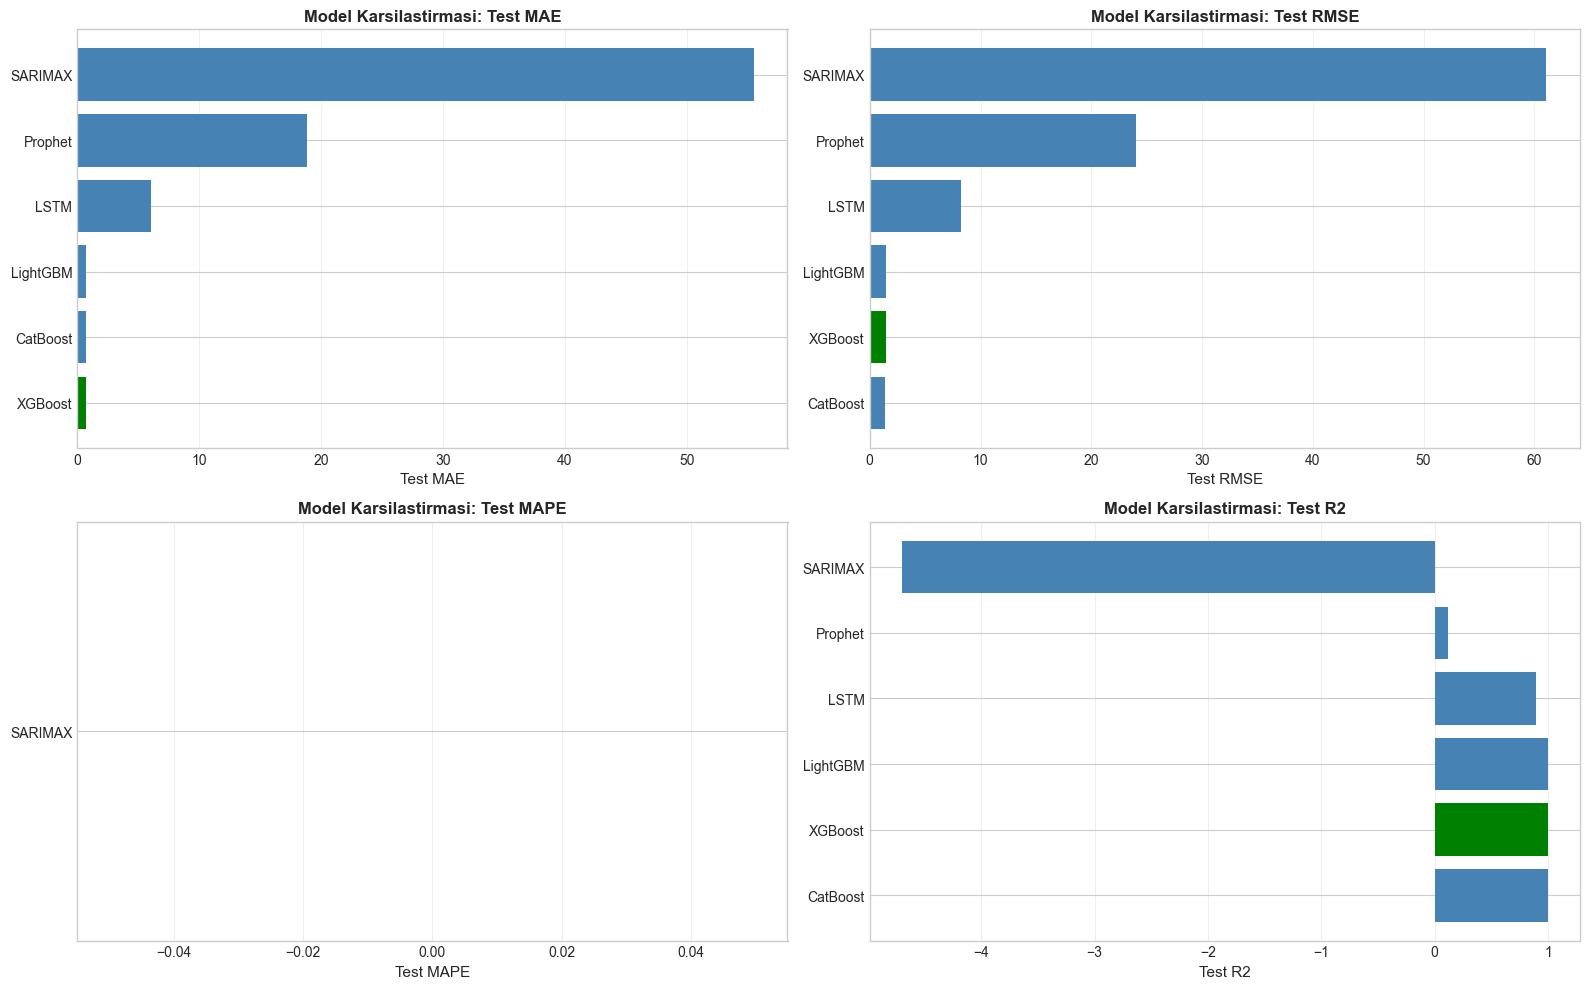


Model karsilastirma grafigi kaydedildi


In [56]:
print("\nModel karsilastirmasi...")

import os
output_dir = os.path.join('..', 'outputs')
os.makedirs(output_dir, exist_ok=True)

comparison_df = pd.DataFrame({
    'Model': ['SARIMAX', 'XGBoost', 'LSTM', 'LightGBM', 'CatBoost', 'Prophet'],
    'Test MAE': [
        test_metrics_sarimax['MAE'],
        test_metrics_xgb['MAE'],
        test_metrics_lstm['MAE'],
        test_metrics_lgb['MAE'],
        test_metrics_catboost['MAE'],
        test_metrics_prophet['MAE']
    ],
    'Test RMSE': [
        test_metrics_sarimax['RMSE'],
        test_metrics_xgb['RMSE'],
        test_metrics_lstm['RMSE'],
        test_metrics_lgb['RMSE'],
        test_metrics_catboost['RMSE'],
        test_metrics_prophet['RMSE']
    ],
    'Test MAPE': [
        test_metrics_sarimax['MAPE'],
        test_metrics_xgb['MAPE'],
        test_metrics_lstm['MAPE'],
        test_metrics_lgb['MAPE'],
        test_metrics_catboost['MAPE'],
        test_metrics_prophet['MAPE']
    ],
    'Test R2': [
        test_metrics_sarimax['R2'],
        test_metrics_xgb['R2'],
        test_metrics_lstm['R2'],
        test_metrics_lgb['R2'],
        test_metrics_catboost['R2'],
        test_metrics_prophet['R2']
    ]
})

print("\n" + "="*80)
print("MODEL KARSILASTIRMA TABLOSU")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

best_model_idx = comparison_df['Test MAE'].idxmin()
best_model_name = comparison_df.loc[best_model_idx, 'Model']

print(f"\nEN IYI MODEL: {best_model_name}")
print(f"Test MAE: {comparison_df.loc[best_model_idx, 'Test MAE']:.4f} cents/kWh")
print(f"Test MAPE: {comparison_df.loc[best_model_idx, 'Test MAPE']:.4f}%")
print(f"Test R2: {comparison_df.loc[best_model_idx, 'Test R2']:.4f}")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

metrics = ['Test MAE', 'Test RMSE', 'Test MAPE', 'Test R2']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    sorted_df = comparison_df.sort_values(metric, ascending=(metric != 'Test R2'))
    colors = ['green' if model == best_model_name else 'steelblue' for model in sorted_df['Model']]
    ax.barh(sorted_df['Model'], sorted_df[metric], color=colors)
    ax.set_xlabel(metric, fontsize=11)
    ax.set_title(f'Model Karsilastirmasi: {metric}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()

save_path = os.path.join(output_dir, 'model_comparison.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("\nModel karsilastirma grafigi kaydedildi")


TAHMIN GORSELLESTIRME

In [57]:
print("\nTahmin grafikleri olusturuluyor...")

fig, axes = plt.subplots(3, 2, figsize=(18, 14))

test_dates = test_data['DateTime'].values
sample_size = min(500, len(test_data))

models_predictions = {
    'XGBoost': y_test_pred_xgb,
    'LightGBM': y_test_pred_lgb,
    'CatBoost': y_test_pred_catboost,
    'LSTM': y_test_pred_lstm if len(y_test_pred_lstm) == len(y_test) else np.concatenate([np.full(len(y_test) - len(y_test_pred_lstm), np.nan), y_test_pred_lstm]),
    'Prophet': y_test_pred_prophet if 'prophet_trained' in locals() and prophet_trained else np.full(len(y_test), np.nan),
    'SARIMAX': y_test_pred_sarimax if 'sarimax_trained' in locals() and sarimax_trained else np.full(len(y_test), np.nan)
}

for idx, (model_name, predictions) in enumerate(models_predictions.items()):
    ax = axes[idx // 2, idx % 2]
    
    ax.plot(test_dates[-sample_size:], y_test.values[-sample_size:], 
            label='Gercek', linewidth=2, alpha=0.7)
    ax.plot(test_dates[-sample_size:], predictions[-sample_size:], 
            label='Tahmin', linewidth=2, alpha=0.7)
    
    ax.set_title(f'{model_name} Tahmin Sonuclari', fontsize=12, fontweight='bold')
    ax.set_xlabel('Tarih')
    ax.set_ylabel('Fiyat (cents/kWh)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('predictions.png', dpi=300, bbox_inches='tight')
plt.close()

print("Tahmin grafikleri kaydedildi")


Tahmin grafikleri olusturuluyor...
Tahmin grafikleri kaydedildi


MODEL KAYDETME

In [58]:
import os
import pickle

print("\nModeller kaydediliyor...")

# model klasörü yoksa oluştur
model_dir = "model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print(f"'{model_dir}' klasörü oluşturuldu")
else:
    print(f"'{model_dir}' klasörü mevcut, kaydetme işlemine devam ediliyor...")

# Kaydedilecek modeller sözlüğü
models_dict = {
    'SARIMAX': sarimax_fit if 'sarimax_fit' in locals() and sarimax_trained else None,
    'XGBoost': xgb_model,
    'LightGBM': lgb_model,
    'CatBoost': catboost_model,
    'Prophet': prophet_model if 'prophet_model' in locals() and prophet_trained else None,
    'LSTM': lstm_model
}

# Modelleri kaydet
for model_name, model_obj in models_dict.items():
    if model_obj is not None:
        try:
            if model_name == 'LSTM':
                save_path = f"{model_dir}/model_{model_name.lower()}.h5"
                model_obj.save(save_path)
            else:
                save_path = f"{model_dir}/model_{model_name.lower()}.pkl"
                with open(save_path, 'wb') as f:
                    pickle.dump(model_obj, f)

            print(f" {model_name} başarıyla kaydedildi → {save_path}")

        except Exception as e:
            print(f" {model_name} kaydedilemedi: {e}")
    else:
        print(f" {model_name} modeli eğitimli değil veya bulunamadı, kaydedilmedi.")

# Scaler ve feature columns kaydetme
try:
    with open(f"{model_dir}/scaler_X.pkl", 'wb') as f:
        pickle.dump(scaler_X, f)
    with open(f"{model_dir}/scaler_y.pkl", 'wb') as f:
        pickle.dump(scaler_y, f)
    with open(f"{model_dir}/feature_columns.pkl", 'wb') as f:
        pickle.dump(feature_cols, f)

    print("\n Scaler ve feature columns başarıyla kaydedildi")

except Exception as e:
    print(f" Scaler/feature columns kaydedilemedi: {e}")



Modeller kaydediliyor...
'model' klasörü oluşturuldu
 SARIMAX başarıyla kaydedildi → model/model_sarimax.pkl
 XGBoost başarıyla kaydedildi → model/model_xgboost.pkl


 LightGBM başarıyla kaydedildi → model/model_lightgbm.pkl
 CatBoost başarıyla kaydedildi → model/model_catboost.pkl
 Prophet başarıyla kaydedildi → model/model_prophet.pkl
 LSTM başarıyla kaydedildi → model/model_lstm.h5

 Scaler ve feature columns başarıyla kaydedildi


SONUC OZETI

In [59]:
print("\n" + "="*80)
print("PROJE TAMAMLANDI")
print("="*80)

print(f"\nVeri Boyutu: {len(df_features)} satir")
print(f"Ozellik Sayisi: {len(feature_cols)}")
print(f"Egitim: {len(train_data)} | Validasyon: {len(val_data)} | Test: {len(test_data)}")

print("\nModel Performans Siralaması (Test MAE):")
sorted_df = comparison_df.sort_values('Test MAE')
for idx, (_, row) in enumerate(sorted_df.iterrows(), 1):
    print(f"{idx}. {row['Model']}: MAE={row['Test MAE']:.4f}, MAPE={row['Test MAPE']:.4f}%, R2={row['Test R2']:.4f}")

print(f"\nKaydedilen dosyalar:")
print("- model_sarimax.pkl")
print("- model_xgboost.pkl")
print("- model_lightgbm.pkl")
print("- model_catboost.pkl")
print("- model_prophet.pkl")
print("- model_lstm.h5")
print("- scaler_X.pkl, scaler_y.pkl, feature_columns.pkl")
print("\nGrafik dosyalari:")
print("- eda_basic.png")
print("- decomposition.png")
print("- acf_pacf.png")
print("- external_variables.png")
print("- correlation_matrix.png")
print("- model_comparison.png")
print("- predictions.png")

print("\n" + "="*80)



PROJE TAMAMLANDI

Veri Boyutu: 56330 satir
Ozellik Sayisi: 87
Egitim: 45064 | Validasyon: 5633 | Test: 5633

Model Performans Siralaması (Test MAE):
1. XGBoost: MAE=0.7033, MAPE=inf%, R2=0.9968
2. CatBoost: MAE=0.7141, MAPE=inf%, R2=0.9972
3. LightGBM: MAE=0.7583, MAPE=inf%, R2=0.9965
4. LSTM: MAE=6.0502, MAPE=inf%, R2=0.8971
5. Prophet: MAE=18.8791, MAPE=inf%, R2=0.1160
6. SARIMAX: MAE=55.4871, MAPE=inf%, R2=-4.6980

Kaydedilen dosyalar:
- model_sarimax.pkl
- model_xgboost.pkl
- model_lightgbm.pkl
- model_catboost.pkl
- model_prophet.pkl
- model_lstm.h5
- scaler_X.pkl, scaler_y.pkl, feature_columns.pkl

Grafik dosyalari:
- eda_basic.png
- decomposition.png
- acf_pacf.png
- external_variables.png
- correlation_matrix.png
- model_comparison.png
- predictions.png

